
# Low-Resource Classification of Life Sciences and GxP-Relevant Applications #

## Goal ##

This case study was developed as part of a job interview assignment and demonstrates a practical approach to classifying enterprise applications relevant to Life Sciences, MedTech, and GxP-regulated environments under low-resource conditions. 
The objective is to design an interpretable and reproducible text-based classification pipeline that can identify potentially regulated applications using limited labeled data and unstructured metadata.

## Requirements ##

- Development of at least two different classification approaches (e.g. ML-based, vector space approaches).
- Annotation and verification of the data
- Visualization of the results (e.g. confusion matrix, feature imports,
embedding plots)
- Identification and explanation of the most relevant features for the classification
- Documentation of the strategy, choice of method and assumptions

In [1]:
# ------------------------------------------------------------
# Import libraries
# ------------------------------------------------------------

import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_predict,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay
)

from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
import umap

### Preprocessing and Annotation Steps ###

The raw data is provided as a nested JSON file, where each key represents an application ID and its value is a dictionary of metadata fields. For further processing, the JSON object is converted into a structured pandas DataFrame. 
Application IDs are extracted from the dictionary keys and added as a separate _AppID_ column to preserve a stable identifier.

To construct a textual representation suitable for classification, several text-based metadata fields likely to contain domain-relevant information are selected, including _AppName_, _AppKeyFeatures_, _GTMAppDescription_, _BusinessRoleDescription_, _ApplicationComponentText_, _Title_, and _CombinedTitle_. These fields are concatenated into a single text column (_FullText_), with missing values replaced by empty strings. The resulting text is lowercased and lightly normalized while preserving domain-specific tokens such as “GxP” or “S/4HANA”.

Because no ground-truth labels were provided, a low-resource annotation strategy is adopted. Keyword-based heuristics are first used only to prioritize candidate applications for manual review. Based on this sampling strategy, a small but representative subset of applications is manually annotated with a binary relevance label indicating whether an application is specific to Life Sciences, MedTech, Pharma, or supports processes typically subject to GxP regulation. Ambiguous cases are explicitly flagged and excluded from the manually verified gold-standard subset used for training and evaluation. The resulting subset serves as ground truth for model development, while the trained classifiers are subsequently applied to the full dataset.

In [16]:
# ------------------------------------------------------------
# Load raw JSON data and convert to a DataFrame
# ------------------------------------------------------------

# read JSON file (structure: {AppID: {metadata fields}}
with open("fiori_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# convert dictionary to DataFrame -> JSON keys (AppIDs) become the index
df = pd.DataFrame.from_dict(data, orient="index")

# move AppID from index into a regular column
df = df.reset_index().rename(columns={"index": "AppID"})

df.head()

,AppID,AppKeyFeatures,AppName,AppType,ApplicationComponentText,BusinessRoleDescription,CombinedTitle,Description,ExternalReleaseName,GTMAppDescription,...,LeadingLob,PFDBIndustry,RoleCombinedToolTipDescription,ScopeItemDescription,ScopeItemID,SolutionsCapability,Subtitle,Title,fioriId,releaseId
0,1KE4,You can obtain overviews for the following o...,Profit Center Assignment Monitor,SAP GUI,Profit Center Accounting,Divisional Accountant,Profit Center Assignment Monitor,None,SAP S/4HANA 2023 FPS01,The assignment monitor provides you with an ...,...,,,Divisional Accountant : \r\nDefines division-r...,None,None,,,Profit Center Assignment Monitor,1KE4,S28OP
1,AB08,,Reverse Journal Entry - Asset Accounting-Specific,SAP GUI,Basic Functions,Asset Accountant,Reverse Journal Entry - Asset Accounting-Specific,None,SAP S/4HANA 2023 FPS01,This app is a SAP GUI for HTML transaction. Th...,...,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting - Group Ledger IFRS|Asset Acc...,1GB|J62,,Asset Accounting-Specific,Reverse Journal Entry,AB08,S28OP
2,ABAAL,The Asset Accounting component consists of th...,Post Depreciation Manually - Unplanned and Pla...,SAP GUI,Asset Accounting,Asset Accountant,Post Depreciation Manually - Unplanned and Pla...,None,SAP S/4HANA 2023 FPS01,Asset Accounting in the SAP system is used fo...,...,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting - Group Ledger IFRS|Asset Acc...,1GB|J62,,Unplanned and Planned,Post Depreciation Manually,ABAAL,S28OP
3,ABAON,,Post Retirement (Non-Integrated) - Without Cus...,SAP GUI,Basic Functions,Asset Accountant,Post Retirement (Non-Integrated) - Without Cus...,None,SAP S/4HANA 2023 FPS01,This app is a SAP GUI for HTML transaction. Th...,...,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting - Group Ledger IFRS|Asset Acc...,1GB|J62,,Without Customer,Post Retirement (Non-Integrated),ABAON,S28OP
4,ABAVN,,Post Retirement - By Scrapping,SAP GUI,Basic Functions,Asset Accountant,Post Retirement - By Scrapping,None,SAP S/4HANA 2023 FPS01,This app is a SAP GUI for HTML transaction. Th...,...,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting|Asset Accounting - Group Ledg...,J62|1GB,,By Scrapping,Post Retirement,ABAVN,S28OP


In [ ]:
# ------------------------------------------------------------
# Create a single text column ("FullText") based on multiple potentially relevant columns
# ------------------------------------------------------------

# select columns which may contain useful domain information
text_columns = [
    "AppName",
    "AppKeyFeatures",
    "GTMAppDescription",
    "BusinessRoleDescription",
    "ApplicationComponentText",
    "Title",
    "CombinedTitle"
]


# combine all selected text fields into one column
#    - missing values are replaced with empty strings
#    - text is joined with spaces
df["FullText"] = (
    df[text_columns]
    .fillna("")
    .agg(" ".join, axis=1)
)

# clean and normalize text without removing domain-relevant symbols (e.g. "/" in S/4HANA)
df["FullText"] = (
    df["FullText"]
    .astype(str)                     # ensure string type
    .str.lower()                     # lowercase for consistency
    .str.replace(r"\s+", " ", regex=True)            # normalize whitespace
    .str.replace(r"[^\w\s\-/+]", " ", regex=True)    # keep -, /, +
    .str.replace(r"\s+", " ", regex=True)            # normalize again
    .str.strip()                     # remove leading/trailing spaces
)

df[["AppID", "FullText"]].head()

,AppID,FullText
0,1KE4,profit center assignment monitor you can obtai...
1,AB08,reverse journal entry - asset accounting-speci...
2,ABAAL,post depreciation manually - unplanned and pla...
3,ABAON,post retirement non-integrated - without custo...
4,ABAVN,post retirement - by scrapping this app is a s...


In [ ]:
# ------------------------------------------------------------
# Sampling for manual labeling (binary relevance)
# Goal: create a small CSV for manual review with a mix of
#   (a) likely relevant apps (keyword matches)
#   (b) likely non-relevant apps (random from the rest)
# ------------------------------------------------------------

# extract a keyword list wuth GxP/Life Sciences relevant words (used only for sampling candidates, not as final labels)
keywords = [
    "gxp", "gmp", "glp", "gcp",
    "pharma", "pharmaceutical", "biotech",
    "life science", "lifescience",
    "clinical", "trial", "patient",
    "medtech", "medical device", "ivd",
    "laboratory", "laboratories", "lab",
    "lims", "lmis",
    "diagnostic", "radiology", "radiological",
    "drug", "medication",
    "validation", "audit", "qa", "qc", "capa",
    "batch", "lot"
]

# keep special characters if they appear and join with "|" (OR)
pattern = r"\b(?:%s)\b" % "|".join(re.escape(k) for k in keywords)

# extract apps where the "FullText" column contains at least one keyword
triage_pos = df[df["FullText"].str.contains(pattern, regex=True, na=False)]

# extract everything else (used to sample non-relevant examples)
triage_neg_pool = df[~df["AppID"].isin(triage_pos["AppID"])]

# take 80 examples from each pool
n_pos = min(80, len(triage_pos))
n_neg = min(80, len(triage_neg_pool))

# sample and combine (random_state for reproducibility)
to_label = pd.concat([
    triage_pos.sample(n_pos, random_state=42),
    triage_neg_pool.sample(n_neg, random_state=42),
]).drop_duplicates("AppID").reset_index(drop=True)

# create a small labeling sheet for manual annotation:
# is_relevant: 1 (relevant) or 0 (not relevant)
# uncertain: 1 if ambiguous / unclear (these are excluded later)
label_df = to_label[["AppID", "AppName", "FullText"]].copy()
label_df["is_relevant"] = ""   # filled manually with 0/1
label_df["uncertain"] = ""     # filled manually with 0/1

# export to CSV 
label_df.to_csv("app_labels.csv", index=False)

print(f"Saved app_labels.csv with {len(label_df)} rows "
      f"({n_pos} keyword-based + {n_neg} random non-keyword).")

Saved app_labels.csv with 160 rows (80 keyword-based + 80 random non-keyword).


In [19]:
# ------------------------------------------------------------
# Prepare the labeled dataset for modeling
# ------------------------------------------------------------

# load the CSV file containing the manually annotated labels
labels = pd.read_csv("app_labels_annotated.csv")

# keep only rows where a relevance label is present
labels = labels.dropna(subset=["is_relevant"])

# exclude ambiguous cases from training and evaluation (apps marked as "uncertain" are not used as ground truth)
labels = labels[labels["uncertain"].fillna(0).astype(int) != 1].copy()

# define model inputs (X) and target labels (y)
#    X: combined text description of each app
#    y: binary relevance label (1 = relevant, 0 = not relevant)
X = labels["FullText"].astype(str)
y = labels["is_relevant"].astype(int)

# check to understand dataset size and balance
print("Number of labeled apps used:", len(labels))
print("Class distribution:")
print(y.value_counts())


Number of labeled apps used: 160
Class distribution:
is_relevant
1    86
0    74
Name: count, dtype: int64



## Method 1: TF-IDF + Logistic Regression
### Method Choice & Assumptions ###

Since the goal is to build a binary classifier that identifies apps relevant to Life Sciences, MedTech, or pharmaceutical/GxP contexts in a low-resource setting, a small labeled dataset had to be created. Keyword-based heuristics were used only to prioritize candidates for manual review (i.e., enrich the sample with likely positives). Based on this sampled subset, applications were manually annotated with a binary relevance label. Ambiguous cases were flagged and excluded from the gold-standard subset used for training and evaluation.

The initial classifier is built using a combination of TF-IDF vectorization and Logistic Regression. TF-IDF (Term Frequency–Inverse Document Frequency) transforms each app’s text into a numerical vector based on how important each word is within the corpus. This captures which terms are distinctive for certain apps (e.g., “batch”, “validation”, or “clinical” may appear more often in relevant apps but rarely overall). Logistic Regression was chosen because it is interpretable (assigns a weight to each input feature) and well suited for binary classification with high-dimensional sparse inputs such as TF-IDF vectors. It learns feature weights to estimate a probability for the positive class (here: relevant app). Additionally, class_weight="balanced" was enabled so the classifier accounts for class imbalance by giving higher weight to the minority class, which helps prevent the model from defaulting to the majority label.



              precision    recall  f1-score   support

           0      0.667     0.568     0.613        74
           1      0.670     0.756     0.710        86

    accuracy                          0.669       160
   macro avg      0.668     0.662     0.662       160
weighted avg      0.669     0.669     0.665       160



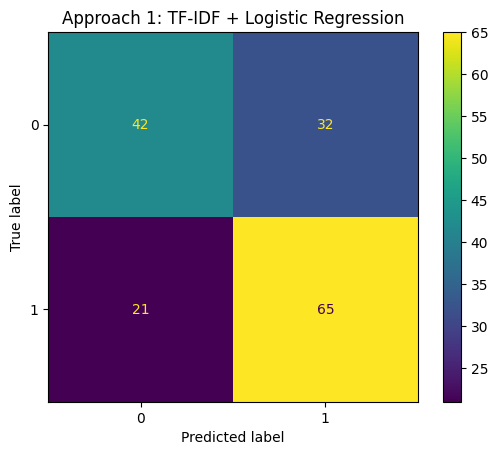

In [20]:
# ------------------------------------------------------------
# Method 1: TF-IDF + Logistic Regression
# ------------------------------------------------------------

# build a pipeline that combines text vectorization and classification into a single, reproducible workflow
pipe_lr = Pipeline([

    # convert text into numerical features using TF-IDF
    # - unigrams and bigrams are used to capture short phrases
    # - very rare and very frequent terms are filtered out
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),

    # Logistic Regression classifier
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=2000
    ))
])

# define stratified cross-validation (preserves the ratio of relevant vs. non-relevant apps in each fold, which is important for imbalanced datasets
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# generate cross-validated predictions: each app is predicted using a model that has not seen it
y_pred = cross_val_predict(pipe_lr, X, y, cv=cv)

# print detailed classification metrics
print(classification_report(y, y_pred, digits=3))

# visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.title("Approach 1: TF-IDF + Logistic Regression")
plt.show()


## Results ##

The classification performance was evaluated using 5-fold stratified cross-validation on a manually annotated subset of 160 applications. The dataset is moderately imbalanced, with 86 relevant and 74 non-relevant applications.

Using a TF-IDF + Logistic Regression model with class weighting, the classifier achieves an overall accuracy of 0.67 and a macro-averaged F1-score of 0.66. For the relevant class (Life Sciences / GxP-relevant applications), 
the model reaches a recall of 0.76 and an F1-score of 0.71, indicating that the majority of relevant applications are correctly identified. While precision for the relevant class (0.67) indicates the presence of false positives, 
this trade-off is acceptable in a low-resource and regulated setting, where missing a relevant application is typically more costly than flagging additional candidates for manual review. 
As expected, performance on the non-relevant class is slightly lower, reflecting semantic overlap between generic ERP terminology and regulated process descriptions.

Overall, the results demonstrate that even with limited labeled data, a simple and interpretable text-based model can capture meaningful domain signals and provide a useful first-level relevance filter.

In [21]:
# ------------------------------------------------------------
# Feature importance analysis 
# Goal: understand which words or phrases most strongly influence the model's relevance predictions.
# ------------------------------------------------------------

# fit the full pipeline on all labeled data (only for inspection, not for evaluation)
pipe_lr.fit(X, y)

# extract the trained components from the pipeline
#    - tfidf: text vectorizer
#    - clf: logistic regression classifier
tfidf = pipe_lr.named_steps["tfidf"]
clf = pipe_lr.named_steps["clf"]

# get the feature names (words / n-grams), corresponding to the TF-IDF dimensions
feature_names = np.array(tfidf.get_feature_names_out())

# extract the learned coefficients from the classifier
#   - positive coefficients push predictions toward "relevant"
#   - negative coefficients push predictions toward "not relevant"
coefs = clf.coef_[0]

# identify the most influential features
#    - top_pos: strongest indicators of relevance
#    - top_neg: strongest indicators of non-relevance
top_pos = feature_names[np.argsort(coefs)[-20:]][::-1]
top_neg = feature_names[np.argsort(coefs)[:20]]

# show results
print("Top POSITIVE features (relevance indicators):")
print(top_pos)

print("\nTop NEGATIVE features (non-relevance indicators):")
print(top_neg)



Top POSITIVE features (relevance indicators):
['inspection' 'lot' 'batch' 'rules' 'payment' 'validation' 'stock'
 'quality' 'audit' 'payments' 'display batch' 'process' 'inspection lot'
 'payable' 'consolidation' 'payment lot' 'trial balance' 'trial'
 'certificate' 'pick']

Top NEGATIVE features (non-relevance indicators):
['sap' 'sales' 'contracts' 'sap fiori' 'bank' 'fiori' 'return' 'product'
 'insurance' 'dunning' 'maintain' 'russia' 'codes' 'display material'
 'billing' 'analysis' 'project' 'manage' 'follow up' 'contract']


## Feature Importance ##

Analysis of the learned feature weights provides insight into the model’s decision-making process. The most influential positive features include terms such as “batch”, “lot”, “inspection”, “validation”, “audit”, “quality”, and “certificate”, 
which are strongly associated with GxP-regulated processes and controlled manufacturing environments.

In contrast, features with strong negative weights are dominated by generic ERP and financial terminology, including “billing”, “bank”, “contracts”, “sales”, and “insurance”, indicating that the model effectively distinguishes administrative business functions from regulated life-science-specific processes.

Notably, several influential features were not explicitly part of the initial keyword heuristics used during sampling. This suggests that the model has generalized beyond simple keyword matching and learned semantically meaningful patterns from the annotated data, supporting the validity of the low-resource annotation strategy.

### -------------------------------------------------------------------------------------------- ###

## Method 2: Embedding-based approach
### Method Choice & Assumptions ###

To complement the keyword- and frequency-based model in Method 1, a vector-space, embedding-based classification approach is applied. Instead of relying directly on sparse word counts, each application description is projected into a dense, 
lower-dimensional semantic space using Latent Semantic Analysis (LSA). 

Text descriptions are first transformed into TF-IDF vectors and subsequently reduced in dimensionality using Truncated Singular Value Decomposition (SVD). This step captures latent semantic structure and allows the model to generalize beyond exact keyword matches by grouping semantically related terms.

For classification, a k-Nearest Neighbors (kNN) classifier with cosine distance is used. This choice is suited for embedding spaces, as it classifies applications based on similarity to previously labeled examples rather than learning explicit decision boundaries. This behavior is particularly appropriate in low-resource settings where labeled data is limited.

The approach makes the assumption that applications with similar semantic content cluster together in the embedding space, enabling relevance classification based on proximity to known Life Sciences / GxP-relevant examples.

              precision    recall  f1-score   support

           0      0.662     0.689     0.675        74
           1      0.723     0.698     0.710        86

    accuracy                          0.694       160
   macro avg      0.693     0.693     0.693       160
weighted avg      0.695     0.694     0.694       160



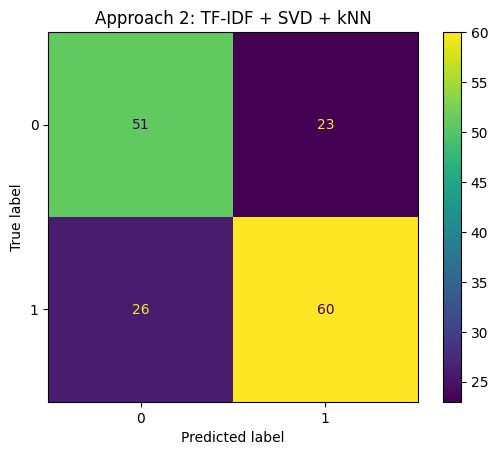

In [ ]:
# ------------------------------------------------------------
# Method 2: Embedding-based classification (TF-IDF + SVD + kNN)
# ------------------------------------------------------------

# convert text into TF-IDF features (same settings as Method 1 for comparability)
tfidf_vec = TfidfVectorizer(
    ngram_range=(1, 2),   # use unigrams + bigrams
    min_df=2,             # ignore very rare terms
    max_df=0.95           # ignore very frequent terms
)

# fit vectorizer on all labeled texts and transform them into a sparse matrix
X_tfidf = tfidf_vec.fit_transform(X)

# reduce dimensionality with Truncated SVD, which creates a dense, lower-dimensional representation (embedding-like vectors)
# and helps generalize beyond exact keyword matches
svd = TruncatedSVD(
    n_components=min(100, X_tfidf.shape[1] - 1),  # keep up to 100 components
    random_state=42                                # ensure reproducible results
)

X_vec = svd.fit_transform(X_tfidf)

# k-Nearest Neighbors classifier in embedding space: the model predicts a label based on the most similar labeled examples
knn = KNeighborsClassifier(
    n_neighbors=5,        # look at 5 nearest examples
    metric="cosine"       # use cosine distance as similarity metric
)

# cross-validated predictions: each sample is predicted by a model that has not seen it in training
y_pred_knn = cross_val_predict(knn, X_vec, y, cv=cv)

# show metrics and confusion matrix
print(classification_report(y, y_pred_knn, digits=3))

ConfusionMatrixDisplay.from_predictions(y, y_pred_knn)
plt.title("Approach 2: TF-IDF + SVD + kNN")
plt.show()


C:\Users\EvaRichter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


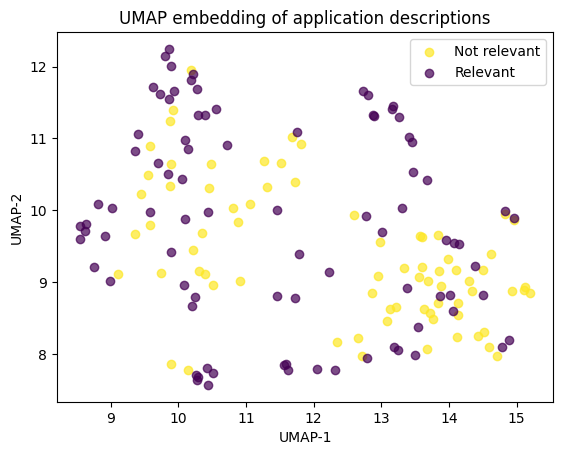

In [31]:
# ------------------------------------------------------------
# Visualizing text embeddings with UMAP
# ------------------------------------------------------------

# Purpose: Reduce the high-dimensional embedding vectors to 2 dimensions
# to visually inspect how relevant and non-relevant apps are distributed in semantic space.

# initialize the UMAP reducer
#    - n_neighbors controls how local vs. global the structure is
#    - min_dist controls how tightly points are packed together
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

# project high-dimensional embeddings into 2D space
X_2d = reducer.fit_transform(X_vec)

# create a scatter plot of the 2D embeddings
#    - each point represents one application
#    - color indicates the relevance label (0 = not relevant, 1 = relevant)
color_not_relevant = "#440154"   # dark violet
color_relevant = "#FDE725"       # yellow

plt.figure()

# non-relevant apps (class 0)
plt.scatter(
    X_2d[y == 0, 0],
    X_2d[y == 0, 1],
    c = color_relevant,
    label="Not relevant",
    alpha=0.7
)

# relevant apps (class 1)
plt.scatter(
    X_2d[y == 1, 0],
    X_2d[y == 1, 1],
    c = color_not_relevant,
    label="Relevant",
    alpha=0.7,
)

plt.title("UMAP embedding of application descriptions")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.show()



## Results ##

The embedding-based approach was evaluated using 5-fold stratified cross-validation on the same manually annotated dataset of 160 applications, consisting of 86 relevant and 74 non-relevant apps.

Using a TF-IDF representation reduced via Singular Value Decomposition (SVD) and a k-Nearest Neighbors classifier, the model achieved an overall accuracy of 0.69 and a macro-averaged F1-score of 0.69. For the relevant class, 
the classifier reached a precision of 0.72, a recall of 0.70, and an F1-score of 0.71, indicating a slightly more conservative but balanced classification behavior compared to the linear baseline.

Compared to the TF-IDF + Logistic Regression model, this approach yields higher precision for relevant applications at the cost of a small reduction in recall. This suggests that the embedding-based method is better at filtering out false positives, 
while still retaining the majority of relevant apps.

To further analyze the learned representation, a two-dimensional UMAP (_Uniform Manifold Approximation and Projection_) projection of the reduced embeddings was generated. The visualization reveals partial clustering of relevant applications, while also showing notable overlap between classes. 
This overlap reflects the shared vocabulary and semantic structure of ERP applications, where regulated and non-regulated functionality often coexists within similar business contexts.

Overall, the embedding-based approach demonstrates that dimensionality-reduced semantic representations can slightly improve classification stability and precision in low-resource settings, while also providing useful exploratory insights into the structure of the application space.

## General Conclusion ##

The objective of this task was to identify applications relevant to regulated life sciences, MedTech, and GxP-related domains in a low-resource setting, characterized by limited labeled data and strong class imbalance. 
To address this challenge, two complementary classification approaches were developed and evaluated: a keyword- and frequency-based linear model and a semantic, embedding-based method.

The first approach, using TF-IDF features with Logistic Regression, proved to be a good and interpretable baseline. By incorporating class-weight balancing, the model achieved high recall for relevant applications, ensuring that potentially regulated apps were rarely missed. Feature importance analysis showed that the classifier learned meaningful domain-specific indicators beyond the initial weak-labeling heuristics, demonstrating its ability to generalize from sparse supervision. This makes the approach particularly suitable for early-stage triage scenarios where recall is prioritized over precision.

The second approach extended this baseline by introducing a semantic representation of application descriptions through dimensionality reduction and neighborhood-based classification. While overall performance was comparable, this method achieved higher precision for relevant apps, indicating improved robustness against false positives. Additionally, the embedding-based analysis provided valuable qualitative insights into the structure of the application space, revealing partial clustering of regulated applications and highlighting areas of semantic overlap between classes.

Taken together, the results show that both approaches are suitable and complementary in low-resource classification settings. The linear TF-IDF model offers transparency, ease of deployment, and strong recall, while the embedding-based approach provides improved semantic robustness and exploratory capabilities. In practice, a hybrid strategy, using the linear model for high-recall screening and the embedding-based method for secondary validation or prioritization, could offer an effective and scalable solution.

Future improvements could include expanding the manually labeled dataset using active learning, clarifying domain-specific labeling criteria, and experimenting with stronger sentence embedding models.

## Limitations ##

This study is based on a relatively small, manually annotated subset of applications, which may introduce some label noise, especially for borderline cases. The models rely solely on textual metadata and do not incorporate additional contextual or system-level information that could further improve classification. Finally, the task is framed as a binary relevance problem, whereas real-world scenarios may require finer-grained or multi-label classifications.